In [2]:
import numpy
import pandas
import torch
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
# Load training data
def loadData(tsv_fn, plot = False):
    
    data = pandas.read_csv(tsv_fn, sep = "\t")
    
    if plot:

        data_melt = pandas.melt(data, id_vars="diagnosis")
        sns.boxplot(x="variable", y="value", hue="diagnosis", data=data_melt, palette="Set2")
        
    features = data.iloc[:,:5].values
    labels = data.iloc[:,5].values
    
    return torch.tensor(features, dtype = torch.float), torch.tensor(labels, dtype = torch.float).view(-1,1)

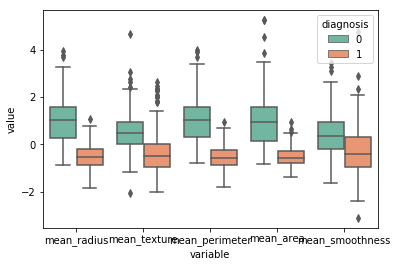

In [12]:
train_features, train_labels = loadData("../data/Breast_cancer_data_scaled_train.tsv", plot = True)

In [13]:
print(train_features.shape)

torch.Size([455, 5])


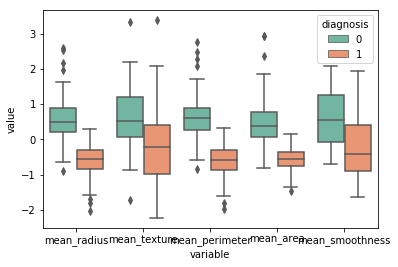

In [14]:
test_features, test_labels = loadData("../data/Breast_cancer_data_scaled_test.tsv", plot = True)

In [15]:
def calcPredictionAccuracy(prob, labels, threshold = 0.5):
    
    assert(not any(torch.isnan(prob)))
    
    predicted_labels = prob > threshold
    correct_labels = predicted_labels.int() == labels.int()
    
    return correct_labels.sum().float() / prob.shape[0]
  

In [16]:
# Logistic regression model
def calcLogisticLogLikelihood(prob, labels):
    
    assert(not any(torch.isnan(prob)))
    log_lik = (labels*(prob.log()) + (1-labels)*((1-prob).log())).sum()
    return log_lik

In [17]:
def addInterceptCol(tensor):
    
    return torch.cat([torch.ones((tensor.shape[0],1), dtype = tensor.dtype), tensor], 1)

DONE.
Train accuracy: 0.9340659379959106
Test accuracy: 0.9298245906829834
tensor([[ 0.7656],
        [-1.3769],
        [-1.6865],
        [-1.7183],
        [-1.9771],
        [-1.9934]], requires_grad=True)


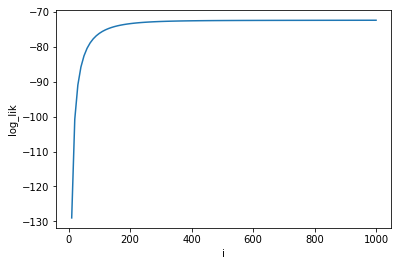

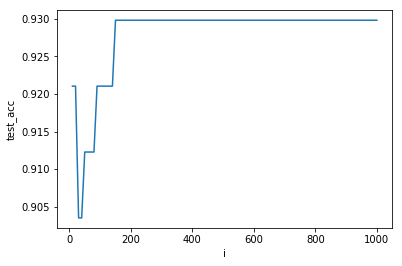

In [18]:
#####
# LOGISTIC REGRESSION
#####

train_features_intercept = addInterceptCol(train_features)
test_features_intercept = addInterceptCol(test_features)

num_iterations = 1000
print_interval = 10
log_lik = numpy.zeros(num_iterations // print_interval)
test_acc = numpy.zeros(num_iterations // print_interval)

betas = torch.rand((6,1), requires_grad = True, dtype = torch.float) 

#optimizer = torch.optim.SGD(betas, lr = 1e-3)
learning_rate = 1e-3

for i in range(num_iterations):

    log_ll = calcLogisticLogLikelihood(torch.sigmoid(torch.mm(train_features_intercept, betas)), train_labels)
    log_ll.backward()
    
    with torch.no_grad():

        betas += learning_rate * betas.grad

    betas.grad.data.zero_()

    if (i + 1) % print_interval == 0:

        # print(f"Iteration {i+1} log-likelihood: {log_ll.item()}")
        log_lik[((i + 1) // print_interval) - 1] = log_ll.item()
        
        with torch.no_grad():

            test_acc[((i + 1) // print_interval) - 1] = calcPredictionAccuracy(torch.sigmoid(torch.mm(test_features_intercept, betas)), test_labels)

with torch.no_grad():
    
    print("DONE.")
    print("Train accuracy:", calcPredictionAccuracy(torch.sigmoid(torch.mm(train_features_intercept, betas)), train_labels).item())
    print("Test accuracy:", calcPredictionAccuracy(torch.sigmoid(torch.mm(test_features_intercept, betas)), test_labels).item())

print(betas)
convergence = pandas.DataFrame({'i': numpy.arange(print_interval,num_iterations+1,print_interval), 'log_lik' : log_lik, "test_acc" : test_acc})

sns.lineplot(x = "i", y = "log_lik", data=convergence)
plt.figure()
sns.lineplot(x = "i", y = "test_acc", data=convergence)

DONE. Finals:
Train accuracy: 0.9340659379959106
Test accuracy: 0.9298245906829834
[('obs.weight', Parameter containing:
tensor([[-1.4033, -1.6847, -2.1002, -1.5254, -1.9810]], requires_grad=True)), ('obs.bias', Parameter containing:
tensor([0.8032], requires_grad=True))]


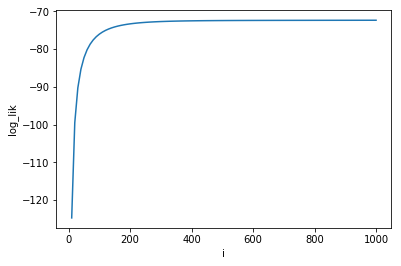

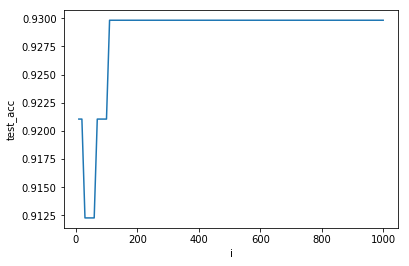

In [11]:
#####
# LOGISTIC REGRESSION (TORCH NET)
#####

class LinearNet(torch.nn.Module):
    
    def __init__(self, input_len):

        super(LinearNet, self).__init__()
        self.obs = torch.nn.Linear(input_len, 1)

    def forward(self, x):
        
        x = self.obs(x)
        return x
    
num_iterations = 1000
print_interval = 10
log_lik = numpy.zeros(num_iterations // print_interval)
test_acc = numpy.zeros(num_iterations // print_interval)

linear_net = LinearNet(5)
optimizer = torch.optim.SGD(linear_net.parameters(), lr = 1e-3)

for i in range(num_iterations):
    
    train_act = linear_net(train_features)
    log_ll = calcLogisticLogLikelihood(torch.sigmoid(train_act), train_labels) * -1
    log_ll.backward()

    optimizer.step()
    linear_net.zero_grad()
    
    if (i + 1) % print_interval == 0:

        # print(f"Iteration {i+1} log-likelihood: {log_ll.item() * -1}")
        log_lik[((i + 1) // print_interval) - 1] = log_ll.item() * -1
        
        with torch.no_grad():

            test_act = linear_net.forward(test_features)
            test_acc[((i + 1) // print_interval) - 1] = calcPredictionAccuracy(torch.sigmoid(test_act), test_labels)

with torch.no_grad():
    
    print("DONE. Finals:")
    train_act = linear_net(train_features)
    print("Train accuracy:", calcPredictionAccuracy(torch.sigmoid(train_act), train_labels).item())
    
    test_act = linear_net(test_features)
    print("Test accuracy:", calcPredictionAccuracy(torch.sigmoid(test_act), test_labels).item())

print(list(linear_net.named_parameters()))
convergence = pandas.DataFrame({'i': numpy.arange(print_interval,num_iterations+1,print_interval), 'log_lik' : log_lik, "test_acc" : test_acc})

sns.lineplot(x = "i", y = "log_lik", data=convergence)
plt.figure()
sns.lineplot(x = "i", y = "test_acc", data=convergence)

DONE. Finals:
Train accuracy: 0.9472527503967285
Test accuracy: 0.9122806787490845


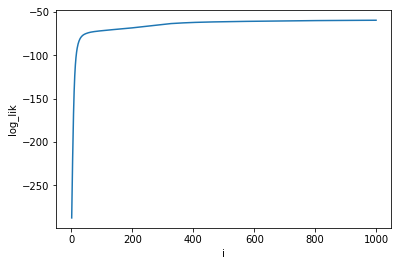

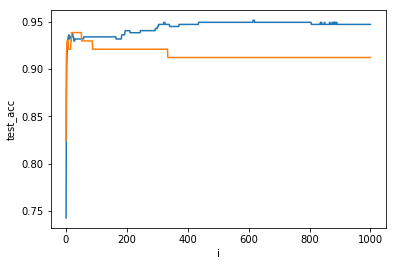

In [12]:
#####
# NEURAL NETWORK MODEL
#####

class NeuralNet(torch.nn.Module):
    
    def __init__(self, input_len, h1_size):

        super(NeuralNet, self).__init__()
        self.h1 = torch.nn.Linear(input_len, h1_size)       
        self.obs = torch.nn.Linear(h1_size, 1)

    def forward(self, x):
        
        x = torch.nn.functional.relu(self.h1(x))
        x = self.obs(x)
        return x
    
h1_size = 10
neural_net = NeuralNet(5, h1_size)

optimizer = torch.optim.SGD(neural_net.parameters(), 1e-3)

num_iterations = 1000
print_interval = 1
log_lik = numpy.zeros(num_iterations // print_interval)
train_acc = numpy.zeros(num_iterations // print_interval)
test_acc = numpy.zeros(num_iterations // print_interval)

criterion = torch.nn.BCEWithLogitsLoss(reduction = "sum")

for i in range(num_iterations):
    
    train_act = neural_net(train_features)

    log_ll = criterion(train_act, train_labels)
#    log_ll = calcLogisticLogLikelihood(torch.sigmoid(train_act), train_labels) * -1
    log_ll.backward()

    optimizer.step()
    neural_net.zero_grad()
    if (i + 1) % print_interval == 0:

        # print(f"Iteration {i+1} log-likelihood: {log_ll.item() * -1}")
        log_lik[((i + 1) // print_interval) - 1] = log_ll.item() * -1
        
        with torch.no_grad():

            train_acc[((i + 1) // print_interval) - 1] = calcPredictionAccuracy(torch.sigmoid(train_act), train_labels)
            test_act = neural_net(test_features)
            test_acc[((i + 1) // print_interval) - 1] = calcPredictionAccuracy(torch.sigmoid(test_act), test_labels)

with torch.no_grad():
    
    print("DONE. Finals:")
    train_act = neural_net(train_features)
    print("Train accuracy:", calcPredictionAccuracy(torch.sigmoid(train_act), train_labels).item())
    
    test_act = neural_net(test_features)
    print("Test accuracy:", calcPredictionAccuracy(torch.sigmoid(test_act), test_labels).item())

convergence = pandas.DataFrame({'i': numpy.arange(print_interval,num_iterations+1,print_interval), 'log_lik' : log_lik, "train_acc" : train_acc, "test_acc" : test_acc})

sns.lineplot(x = "i", y = "log_lik", data=convergence)
plt.figure()
sns.lineplot(x = "i", y = "train_acc", data=convergence)
sns.lineplot(x = "i", y = "test_acc", data=convergence)

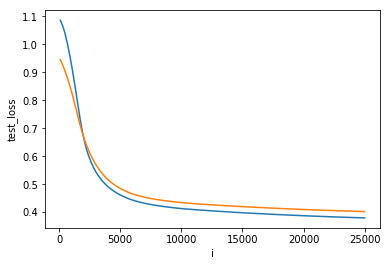

In [13]:
#####
# AUTOENCODER
#####

class Encoder(torch.nn.Module):
    
    def __init__(self, input_size, h1_size, rep_size):

        super(Encoder, self).__init__()
        self.h1 = torch.nn.Linear(input_size, h1_size)       
        self.rep = torch.nn.Linear(h1_size, rep_size)

    def forward(self, x):
        
        x = torch.nn.functional.relu(self.h1(x))
        x = self.rep(x)
        return x

class Decoder(torch.nn.Module):
    
    def __init__(self, input_size, h1_size, rep_size):

        super(Decoder, self).__init__()
        self.h1 = torch.nn.Linear(rep_size, h1_size)       
        self.obs = torch.nn.Linear(h1_size, input_size)

    def forward(self, x):
        
        x = torch.nn.functional.relu(self.h1(x))
        x = self.obs(x)
        return x

h1_size = 3
rep_size = 2
encoder = Encoder(5, h1_size, rep_size)
decoder = Decoder(5, h1_size, rep_size)

optimizer = torch.optim.SGD(list(encoder.parameters()) + list(decoder.parameters()), 1e-3)

num_iterations = 25000
print_interval = 100
train_loss = numpy.zeros(num_iterations // print_interval)
test_loss = numpy.zeros(num_iterations // print_interval)

criterion = torch.nn.MSELoss()

for i in range(num_iterations):
    
    representation = encoder(train_features)
    reconstruction = decoder(representation)
    
    loss = criterion(reconstruction, train_features)
    loss.backward()

    optimizer.step()
    encoder.zero_grad()
    decoder.zero_grad()

    if (i + 1) % print_interval == 0:

        train_loss[((i + 1) // print_interval) - 1] = loss.item()

        with torch.no_grad():

            representation = encoder(test_features)
            reconstruction = decoder(representation)
            test_loss[((i + 1) // print_interval) - 1] = criterion(reconstruction, test_features)

convergence = pandas.DataFrame({'i': numpy.arange(print_interval,num_iterations+1,print_interval), "train_loss" : train_loss, "test_loss" : test_loss})

plt.figure()
sns.lineplot(x = "i", y = "train_loss", data=convergence)
sns.lineplot(x = "i", y = "test_loss", data=convergence)

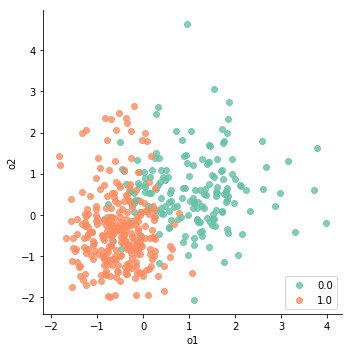

<Figure size 432x288 with 0 Axes>

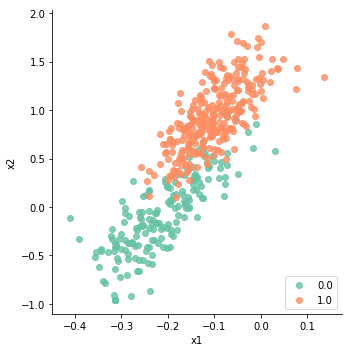

In [61]:
with torch.no_grad():
    
    train_encoding = encoder(train_features)
    
embedding = pandas.DataFrame({"o1": train_features[:,0], "o2": train_features[:,1], "x1" : train_encoding[:,0], "x2" : train_encoding[:,1], "disease" : train_labels[:,0]})
sns.lmplot( x="o1", y="o2", data=embedding, fit_reg=False, hue='disease', legend=False, palette="Set2")
plt.legend(loc='lower right')

plt.figure()
sns.lmplot( x="x1", y="x2", data=embedding, fit_reg=False, hue='disease', legend=False, palette="Set2")
plt.legend(loc='lower right')